### Recap: The Learning Problem

We have a large dataset of $(x, y)$ pairs where $x$ denotes a vector of features and $y$ denotes the label for that feature vector. We want to learn a function $h(x)$ that maps features to labels, with good generalization accuracy. We do this by minimizing a loss function computed on our dataset: $ \sum_{i=1}^{N} L(y_i, h(x_i)) $. There are many loss functions we can choose. We have gone over the cross-entropy loss and variants of the squared error loss functions in previous workshops, and we will once again consider those today. 


### Review: A Single "Neuron", aka the Perceptron

![perceptron](https://raw.githubusercontent.com/rohan-varma/rohan-blog/gh-pages/images/perceptron.png)

A single perceptron first calculates a **weighted sum** of our inputs. This means that we multiply each of our features $(x_1, x_2, ... x_n) \in x$ with an associated weight $(w_1, w_2, ... w_n)$ . We then take the sign of this linear combination, which and the sign tells us whether to classify this instance as a positive or negative example.

$h(x) = sign(w^Tx + b) $

We then moved on to logistic regression, where we changed our sign function to instead be a sigmoid ($\sigma$) function. As a reminder, here's the sigmoid function: 

![sigmoid](https://upload.wikimedia.org/wikipedia/commons/thumb/8/88/Logistic-curve.svg/600px-Logistic-curve.svg.png)

Therefore, the function we compute for logistic regression is $h(x) = \sigma (w^Tx + b)$. 

The sigmoid function is commonly referred to as an "activation" function. When we say that a "neuron computes an activation function", it means that a standard linear combination is calculated ($w^Tx + b$) and then we apply a _non linear_ function to it, such as the sigmoid function. 

Here are a few other common activation functions: 

![tanh](http://www.dplot.com/functions/tanh.png)
![relu](https://i.stack.imgur.com/8CGlM.png)


### Review: From binary to multi-class classification

The most important change in moving from a binary (negative/positive) classification model to one that can classify training instances into many different classes (say, 10, for MNIST) is that our vector of weights $w$ changes into a matrix $W$. 

Each row of weights we learn represents the parameters for a certain class: 

![weights](https://raw.githubusercontent.com/rohan-varma/rohan-blog/gh-pages/images/imagemap.jpg)

We also want to take our output and normalize the results so that they all sum to one, so that we can interpret them as probabilities. This is commonly done using the _softmax_ function, which takes in a vector and returns another vector who's elements sum to 1, and each element is proportional in scale to what it was in the original vector. In binary classification we used the sigmoid function to compute probabilities. Now since we have a vector, we use the softmax function.  

Here is our current model of learning, then:

$h(x) = softmax(Wx + b) $. 

### Building up the neural network

Now that we've figured out how to linearly model multi-class classification, we can create a basic neural network. Consider what happens when we combine the idea of artificial neurons with our softmax classifier. Instead of computing a linear function  $Wx + b$ and immediately passing the output to a softmax function, we have an intermediate step: pass the output of our linear combination to a vector of artificial neurons, which each compute a nonlinear function. 

The output of this "layer" of neurons can be multiplied with a matrix of weights again, and we can apply our softmax function to this result to produce our predictions. 

** Original function **: $h(x) = softmax(Wx + b)$

** Neural Network function **: $h(x) = softmax(W_2(nonlin(W_1x + b_1)) + b_2)$

The key differences are that we have more biases and weights, as well as a larger composition of functions. This function is harder to optimize, and introduces a few interesting ideas about learning the weights with an algorithm known as backpropagation.

This “intermediate step” is actually known as a hidden layer, and we have complete control over it, meaning that among other things, we can vary the number of parameters or connections between weights and neurons to obtain an optimal network. It’s also important to notice that we can stack an arbitrary amount of these hidden layers between the input and output of our network, and we can tune these layers individually. This lets us make our network as deep as we want it. For example, here’s what a neural network with two hidden layers would look like:

![neuralnet](https://raw.githubusercontent.com/rohan-varma/rohan-blog/gh-pages/images/neuralnet.png)

### Quick Example

First, we'll run through a quick example on MNIST. We'll make sure that we can train a basic autoencoder, and see how it performs on reproducting MNIST image. Let's get started with some imports and helper functions to plot images.

Using TensorFlow backend.


Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


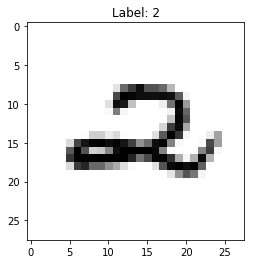

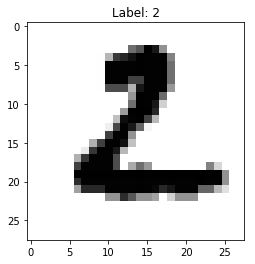

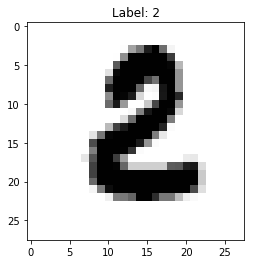

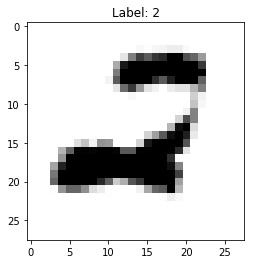

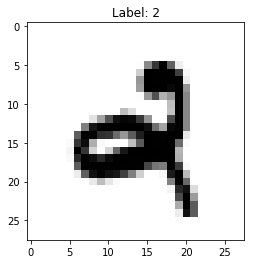

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from tensorflow.examples.tutorials.mnist import input_data
import keras
from keras.datasets import cifar10
mnist = input_data.read_data_sets('MNIST_data', one_hot=True) # reads in the MNIST dataset


# a function that shows examples from the dataset. If num is specified (between 0 and 9), then only pictures with those labels will beused
def show_pics(mnist, num = None):
    to_show = list(range(10)) if not num else [num]*10 # figure out which numbers we should show
    for i in range(100):
        batch = mnist.train.next_batch(1) # gets some examples
        pic, label = batch[0], batch[1]
        if np.argmax(label) in to_show:
            # use matplotlib to plot it
            pic = pic.reshape((28,28))
            plt.title("Label: {}".format(np.argmax(label)))
            plt.imshow(pic, cmap = 'binary')
            plt.show()
            to_show.remove(np.argmax(label))
            
# a function to plot the genned images
def plot(samples, cur_epoch = None, shape = None):
    fig = plt.figure(figsize=(4, 4))
    gs = gridspec.GridSpec(4, 4)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(28,28) if not shape else sample.reshape(shape), cmap='Greys_r')
        # if epoch is not specified we just overwrite the existing image
        plt.show()

    return fig           

#show_pics(mnist)
show_pics(mnist, 2)

### Defining the Model

Below, we'll define our architecture, which will be a fully-connected network that is trained to produce its output. 
We'll also distinguish between transformations that encode images and transformations that take encodings and decode them back into images, and return them both. This is so that we can visualize what features were learned. 

In [2]:
def model(x):
    """Forwards x through the model"""
    dense1 = tf.layers.dense(inputs=x, units=256, activation=tf.nn.relu)
    dense2 = tf.layers.dense(inputs=dense1, units = 100, activation=tf.nn.relu)
    encoded_representation = dense2 
    # that was the encoding, now let's do the decoding
    dense3 = tf.layers.dense(inputs=dense2, units = 1024, activation = tf.nn.relu)
    logits = tf.layers.dense(inputs=dense3, units=784)
    return logits, encoded_representation

Next, we'll define our placeholder variables, loss function, and training step.

In [3]:
x = tf.placeholder(tf.float32, shape = [None, 784])
y = tf.placeholder(tf.float32, shape = [None, 784]) # output is itself
# forward x through the model
logits, encoder = model(x)
# compute loss
training_loss = tf.reduce_mean(tf.square(y-logits))
optim_step = tf.train.AdamOptimizer(learning_rate=0.001).minimize(training_loss)

Now, we'll launch a session and run our model without any training for a baseline.

In [4]:
# launch a sess
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

In [5]:
x_batch, y_batch = mnist.train.next_batch(5)

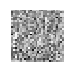

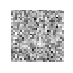

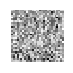

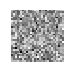

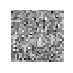

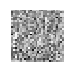

In [6]:
decoded_images = sess.run(logits, feed_dict = {x: x_batch})
plot(decoded_images)

Cool, that seemed to work. Let's see what happens if we train the model for a little bit:

In [26]:
# batch generator for cifar10
def my_generic_batch(dataset, n = 100):
    # assumes dataset is a tuple of (x_train, y_train)
    x_train, y_train = dataset
    indices = np.random.randint(low = 0, high = x_train.shape[0], size = n)
    x_batch, y_batch = x_train[indices], y_train[indices]
    return x_batch, y_batch

#x_batch, y_batch = my_generic_batch((x_train, y_train))
def train_model(optimizer, loss_func, model_logits = logits, dataset = "mnist", n_epochs = 1000, reshape = True):
    # train the model a bit
    for i in range(1000):
        if dataset == "mnist":
            x_batch, y_batch = mnist.train.next_batch(100)
        else:
            x_batch, y_batch = my_generic_batch(dataset)
            if reshape:
                x_batch = x_batch.reshape((100, 32 * 32 * 3))
        optimizer.run(feed_dict = {x: x_batch, y: x_batch})
        if i % 50 == 0:
            cur_loss = loss_func.eval(feed_dict = {x: x_batch, y: x_batch})
            print(cur_loss)
            # sample an image from the model and plot it
            decoded_images = sess.run(model_logits, feed_dict = {x: x_batch[:5]})
            if dataset == "mnist":
                plot(decoded_images)
            else:
                plot(decoded_images, shape = (32, 32, 3))

#train_model(optim_step, training_loss)
#train_model(optimizer = optim_step, loss_func = training_loss, model_logits = logits, dataset = "mnist", n_epochs = 1000)        

In [10]:
# sample 10 test points
test_images, _ = mnist.test.images[:10], mnist.test.labels[:10]
# forward through the model
decoded_images = sess.run(logits, feed_dict = {x: test_images})
encoding = sess.run(encoder, feed_dict = {x: test_images})

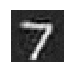

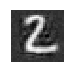

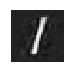

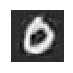

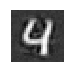

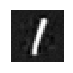

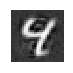

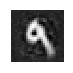

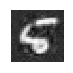

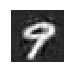

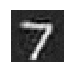

In [11]:
plot(decoded_images)

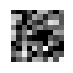

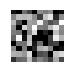

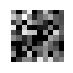

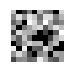

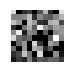

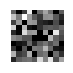

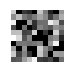

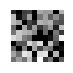

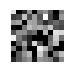

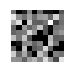

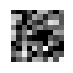

In [12]:
plot(encoding, shape = (10, 10))

Cool, our basic autoencoder seemed to work pretty well. Let's look at a few more advanced examples now. For this, we'll use the CIFAR10 dataset. 

In [13]:
cifar10_data = cifar10.load_data()

In [14]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

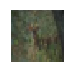

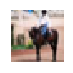

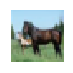

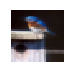

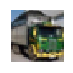

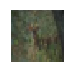

In [15]:
samples = x_train[10:15]
plot(samples, shape = (32, 32, 3))

Let's try our old model again. It's redefined here for convenience (and because we had to change a few shapes). 

In [59]:
def cifar_model(cifar_in):
    """Forwards x through the model"""
    dense1 = tf.layers.dense(inputs=cifar_in, units=256, activation=tf.nn.relu)
    dense2 = tf.layers.dense(inputs=dense1, units = 100, activation=tf.nn.relu)
    encoded_representation = dense2 
    # that was the encoding, now let's do the decoding
    dense3 = tf.layers.dense(inputs=dense2, units = 1024, activation = tf.nn.relu)
    logits = tf.layers.dense(inputs=dense3, units=32 * 32 * 3)
    return logits, encoded_representation

def better_cifar_model(cifar_in):
    """Forwards x through the model"""
    # reshape input back into 32, 32, 3
    x = tf.reshape(cifar_in, [-1, 32, 32, 3])
    input_layer = x
    # Convolutional Layer #1
    conv1 = tf.layers.conv2d(
      inputs=input_layer,
      filters=32,
      kernel_size=[5, 5],
      padding="same",
      activation=tf.nn.relu)

  # Pooling Layer #1
    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)

  # Convolutional Layer #2 and Pooling Layer #2
    conv2 = tf.layers.conv2d(
      inputs=pool1,
      filters=64,
      kernel_size=[5, 5],
      padding="same",
      activation=tf.nn.relu)
    pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)

  # Dense Layer
    pool2_flat = tf.reshape(pool2, [-1, 32 * 10 * 64])
    encoded_representation = pool2_flat
    dense = tf.layers.dense(inputs=pool2_flat, units=1024, activation=tf.nn.relu)
    dropout = tf.layers.dropout(
      inputs=dense, rate=0.4, training=True)

  # Logits Layer
    logits = tf.layers.dense(inputs=dropout, units=32 * 32 * 3)
    return logits, encoded_representation
    
cifar_x = tf.placeholder(tf.float32, shape = [None, 32 * 32 * 3])
cifar_y = tf.placeholder(tf.float32, shape = [None, 32 * 32 * 3]) # output is itself
# forward x through the model
model_type = "good"
cifar_logits, cifar_encoder = cifar_model(cifar_x) if model_type == "bad" else better_cifar_model(cifar_x)
# compute loss
cifar_training_loss = tf.reduce_mean(tf.square(cifar_y-cifar_logits))
cifar_optim_step = tf.train.AdamOptimizer(learning_rate=0.001).minimize(cifar_training_loss)

In [35]:
sess.run(tf.global_variables_initializer())

In [56]:
x_tmp, y_tmp = x_train[:10].reshape((10, 3072)), x_train[:10].reshape((10, 3072))
sess.run(cifar_optim_step, feed_dict = {cifar_x: x_tmp, cifar_y: y_tmp})
# train the model 
for i in range(5):
    x_batch, _ = my_generic_batch((x_train, y_train), n = 10)
    x_batch = x_batch.reshape((x_batch.shape[0], 32 * 32 * 3))
    sess.run(cifar_optim_step, feed_dict = {cifar_x: x_batch, cifar_y: x_batch})

In [57]:
def train_model(optimizer, loss_func, model_logits = logits, dataset = "mnist", n_epochs = 1000, reshape = True):
    # train the model a bit
    for i in range(1000):
        if dataset == "mnist":
            x_batch, y_batch = mnist.train.next_batch(100)
        else:
            x_batch, y_batch = my_generic_batch(dataset, n = 10)
            if reshape:
                print(x_batch.shape)
                x_batch = x_batch.reshape((x_batch.shape[0], 32 * 32 * 3))
        optimizer.run(feed_dict = {cifar_x: x_batch, cifar_y: x_batch})
        if i % 50 == 0:
            cur_loss = loss_func.eval(feed_dict = {cifar_x: x_batch, cifar_y: x_batch})
            print(cur_loss)
            # sample an image from the model and plot it
            decoded_images = sess.run(model_logits, feed_dict = {cifar_x: x_batch[:5]})
            if dataset == "mnist":
                plot(decoded_images)
            else:
                plot(decoded_images, shape = (32, 32, 3))

In [58]:
#NOTE: don't run this with the conv model.
train_model(optimizer = cifar_optim_step, loss_func = cifar_training_loss, model_logits = cifar_logits, dataset = (x_train, y_train), n_epochs = 1000, reshape = True)        

(10, 32, 32, 3)
6355.65


InvalidArgumentError: Input to reshape is a tensor with 20480 values, but the requested shape requires a multiple of 40960
	 [[Node: Reshape_5 = Reshape[T=DT_FLOAT, Tshape=DT_INT32, _device="/job:localhost/replica:0/task:0/cpu:0"](max_pooling2d_6/MaxPool, Reshape_5/shape)]]

Caused by op 'Reshape_5', defined at:
  File "/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/runpy.py", line 170, in _run_module_as_main
    "__main__", mod_spec)
  File "/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2683, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2787, in run_ast_nodes
    if self.run_code(code, result):
  File "/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2847, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-34-da00687bd26e>", line 51, in <module>
    cifar_logits, cifar_encoder = cifar_model(cifar_x) if model_type == "bad" else better_cifar_model(cifar_x)
  File "<ipython-input-34-da00687bd26e>", line 37, in better_cifar_model
    pool2_flat = tf.reshape(pool2, [-1, 64 * 10 * 64])
  File "/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/tensorflow/python/ops/gen_array_ops.py", line 2619, in reshape
    name=name)
  File "/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py", line 767, in apply_op
    op_def=op_def)
  File "/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 2630, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1204, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InvalidArgumentError (see above for traceback): Input to reshape is a tensor with 20480 values, but the requested shape requires a multiple of 40960
	 [[Node: Reshape_5 = Reshape[T=DT_FLOAT, Tshape=DT_INT32, _device="/job:localhost/replica:0/task:0/cpu:0"](max_pooling2d_6/MaxPool, Reshape_5/shape)]]
